# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from bert.tokenization import FullTokenizer

# from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import BertLayer
from layers.attention import AttentionLayer
from models.build_models import *
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
MAX_SEQ_LEN = 30

In [8]:
# sentences_wttarg = proc_sentences(df_cloze, 'sentence', 'syn1')
# sentences_notarg = proc_sentences(df_cloze, 'sentence', None)
sentences = proc_sentences_dscovar(df_cloze, 'sentence', 'targ', 'bert', MAX_SEQ_LEN)

In [9]:
sentences

[array(['discord', 'rakish', 'defile', ..., 'deviate', 'frigid', 'adhere'],
       dtype='<U12'),
 array([' A discord  emerged between the two who were once friends . ',
        ' A bohemian is a person who is free-spirited and rakish  . ',
        ' A bunch of kids had broken in and defile  the paintings . ', ...,
        ' You will not get lost if you stay straight and do not deviate  . ',
        " You'll find what you're looking for when it becomes more frigid  . ",
        " Your plan's nice, but I doubt I could adhere  to it for long . "],
       dtype='<U109')]

In [10]:
len(sentences[0])

1783

In [11]:
# import pickle
# with open("dscovar_sentences_bert.pickle", "wb") as f: pickle.dump(sentences, f)

In [12]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_brt = resp_scores[:, 1]
resp_lmo = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
spearmanr(resp_glv, resp_bws)

SpearmanrResult(correlation=0.29171271599311266, pvalue=2.5929076452565018e-36)

In [14]:
spearmanr(resp_brt, resp_bws)

SpearmanrResult(correlation=0.45246029896699846, pvalue=1.0789045197207714e-90)

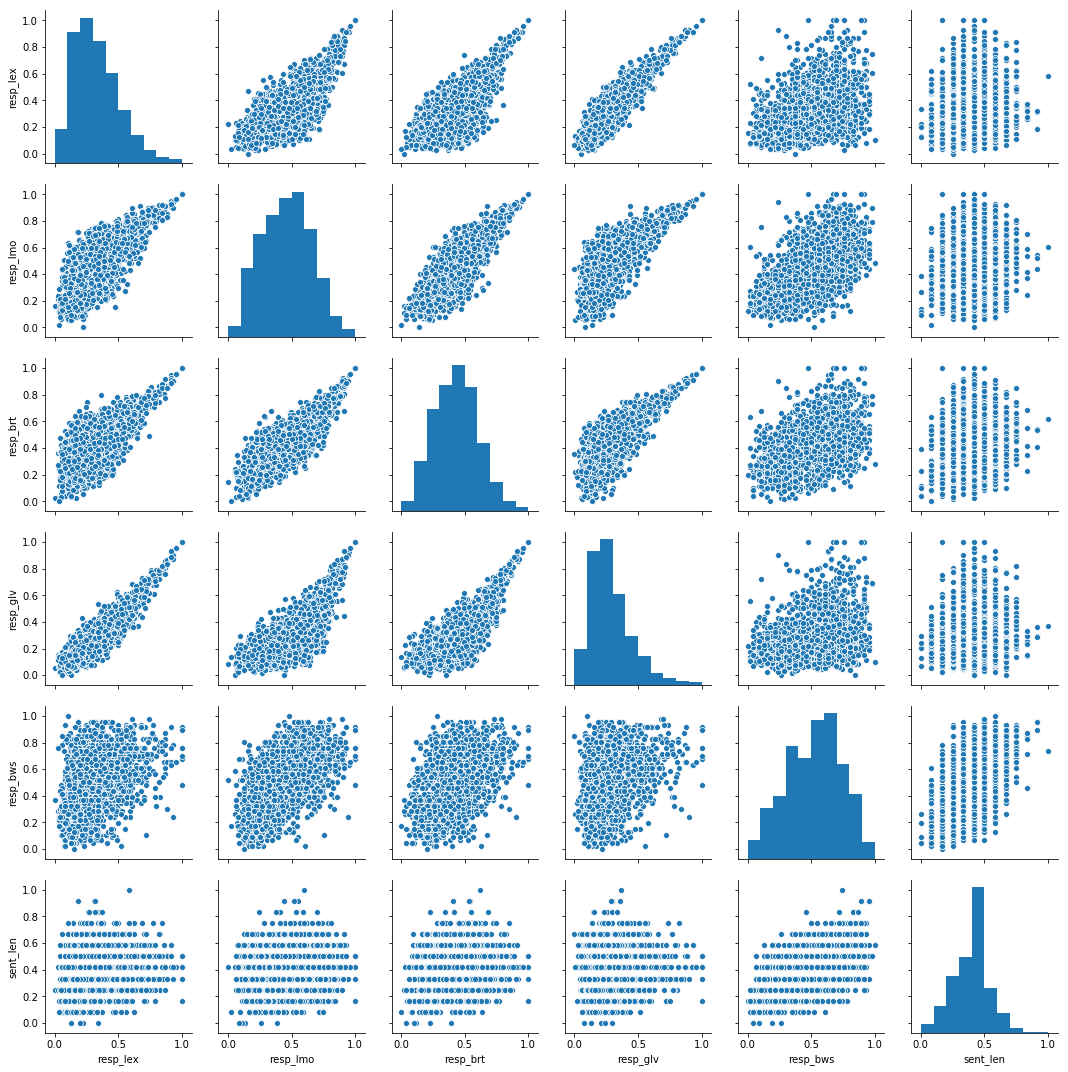

In [15]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

In [16]:
tokenizer = create_tokenizer_from_hub_module()
train_examples = convert_text_to_examples(sentences[0], sentences[1], resp_bws)
tt = convert_examples_to_features(tokenizer, train_examples[:1], False, MAX_SEQ_LEN)
tt[:4]

(array([[ 138,  103, 5338, 1206, 1103, 1160, 1150, 1127, 1517, 2053,  119,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]),
 array([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]))

# BERT + Attention model
- 1emb
- lr: 3e-5
- batch: 16
- iter: 5
- TODO: use validation set (from the training part) to select the hyperparameter?

In [17]:
gkf1 = GroupKFold(n_splits=10) ## target words

## 1-1. No tune, no attention

In [18]:
_l_rate = 3e-5
_batch_size = 16
_num_iter = 5

In [19]:
# MAX_SEQ_LEN = 150
# _l_rate = 3e-5

# K.clear_session()
# sess = tf.Session()

# model_bert = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=_l_rate)
# initialize_vars(sess)

# model_bert.summary()

In [20]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_nt_na = train_bertmod_cv(sentences, resp_glv, False,
                                gkf_split,
                                False, False, False,
                                None, None, 
                                MAX_SEQ_LEN, 3e-5, 5, 16)

KeyboardInterrupt: 

In [ ]:
np.save("bert_result_nt_na_out_glv.npy", [result_nt_na['test_evals'], result_nt_na['test_trues']])

## 1-2. No tune, /w attention

In [ ]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_nt_wa = train_bertmod_cv(sentences, resp_glv, False,
                                gkf_split,
                                False, True, False,
                                None, None, 
                                MAX_SEQ_LEN, 3e-5, 5, 16)

In [ ]:
np.save("bert_result_nt_wa_out_glv.npy", [result_nt_wa['test_evals'], result_nt_wa['test_trues']])

## 2-1. fine tune, no attention

In [ ]:
gkf1 = GroupKFold(n_splits=10) ## target words

In [ ]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_ft_na = train_bertmod_cv(sentences, resp_glv, False,
                                gkf_split,
                                True, False, False,
                                None, None, 
                                MAX_SEQ_LEN, 3e-5, 5, 16)

In [ ]:
np.save("bert_result_ft_na_out_glv.npy", [result_ft_na['test_evals'], result_ft_na['test_trues']])

## 2-2. fine tune, /w attention

In [ ]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_ft_wa = train_bertmod_cv(sentences, resp_glv, False,
                                gkf_split,
                                True, True, False,
                                None, None, 
                                MAX_SEQ_LEN, 3e-5, 5, 16)

In [ ]:
np.save("bert_result_ft_wa_out_glv.npy", [result_ft_wa['test_evals'], result_ft_wa['test_trues']])

# Best full model 

## finetuning

In [19]:
_tokenizer = create_tokenizer_from_hub_module()
_train_examples = convert_text_to_examples(sentences[0], sentences[1], resp_bws)
(_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs, _train_scores) = convert_examples_to_features(_tokenizer, _train_examples, False, MAX_SEQ_LEN)

In [20]:
MAX_SEQ_LEN

30

In [21]:
K.clear_session()
sess = tf.Session()

model_bert = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, 
                              sep_cntx_targ=False, lr=3e-5)
initialize_vars(sess)

In [22]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_sent_raw (BertLayer)       (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [21]:
model_bert.fit([_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs], _train_scores,
               epochs=5, batch_size=16, verbose=0,
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=False)])

In [22]:
tt_preds = model_bert.predict([_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs])

In [23]:
model_bert.save_weights("./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_bws_full_i5_b16_lr3e-05____2.tf")
np.save("./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_bws_full_i5_b16_lr3e-05____2.npy", model_bert.get_weights())

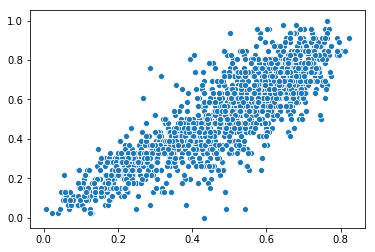

In [24]:
sns.scatterplot(np.reshape(tt_preds, -1), 
               np.reshape(_train_scores, -1))

## notuning

In [25]:
_tokenizer = create_tokenizer_from_hub_module()
_train_examples = convert_text_to_examples(sentences[0], sentences[1], resp_bws)
(_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs, _train_scores) = convert_examples_to_features(_tokenizer, _train_examples, False, MAX_SEQ_LEN)

In [26]:
K.clear_session()
sess = tf.Session()

model_bert = build_model_bert(MAX_SEQ_LEN, finetune_emb=False, attention_layer=True, 
                              sep_cntx_targ=False, lr=3e-5)
initialize_vars(sess)

In [27]:
model_bert.fit([_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs], _train_scores,
               epochs=5, batch_size=16, verbose=0,
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=False)])

In [28]:
tt_preds = model_bert.predict([_train_input_ids, _train_input_masks, _train_segment_ids, _train_targ_locs])

In [29]:
model_bert.save_weights("./model_weights/notune/bert/1emb/model_bert_notune_notarg_wtattn_bws_full_i5_b16_lr3e-05____2.tf")
np.save("./model_weights/notune/bert/1emb/model_bert_notune_notarg_wtattn_bws_full_i5_b16_lr3e-05____2.npy", model_bert.get_weights())

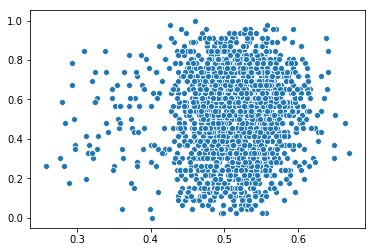

In [30]:
sns.scatterplot(np.reshape(tt_preds, -1), 
               np.reshape(_train_scores, -1))